# Get data

Outputs: df, dfd

In [ ]:
from fastai2.vision.all import *
from fastcore.test import *
import pandas as pd


### Unzip data ###
path = Path('/home/rory/data/coco2017')
path_items = path.ls()
from zipfile import ZipFile
def unzip(*paths,dest):
    """Unzips files located at posixpaths to dest. Deps: zipfile, pathlib."""
    for path in paths:
        if path.suffix == '.zip':
            print(f"Unzipping: {path} ---> {dest}.")
            with ZipFile(path, 'r') as archive:
                archive.extractall(dest)
    new_items = set(dest.ls()) - set(paths)
    print("Finished. New items in dest:",*new_items,sep='\n')
# unzip(*path_items, dest=path)


### Get ims and annos ###
ims_train, annos_train = get_annotations(path/'annotations/instances_train2017.json')
ims_valid, annos_valid = get_annotations(path/'annotations/instances_val2017.json')
ims_train = list(map(lambda x: 'train2017/'+x,ims_train))
ims_valid = list(map(lambda x: 'val2017/'  +x,ims_valid))
ims    = ims_train + ims_valid
annos  = annos_train + annos_valid
bboxes = [i[0] for i in annos]
lbls   = [i[1] for i in annos]


### Process annos ###
def transpose(l): return list(zip(*l))
def bbox_area(anno_t): # takes a transposed anno
    b = anno_t[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = [sort_annos(a) for a in annos]
largest_anno = [i[0] for i in sorted_annos]
largest_bbox = [i[0] for i in largest_anno]
largest_lbl  = [i[1] for i in largest_anno]
is_valid     = [False]*len(ims_train) + [True]*len(ims_valid)

### Store outputs in dfd, df ###
dfd = {
    "im":ims,
    "annos":annos,
    "bboxes":bboxes,
    "lbls":lbls,
    "sorted_annos":sorted_annos,
    "largest_anno":largest_anno,
    "largest_bbox":largest_bbox,
    "largest_lbl":largest_lbl,
    "is_valid":is_valid}
df_all = pd.DataFrame(dfd)

## Get subset

In [ ]:
subset_fraction = .01

df = pd.DataFrame(df_all[['im', 'largest_bbox', 'largest_lbl', 'is_valid']]
                     .sample(frac=subset_fraction)
                     .reset_index()
                     .drop(columns='index')        # Note that drop creates a copy, so using
                    ).copy()                       ## .copy() is reundant (but good practice).
df.head(1)

,im,largest_bbox,largest_lbl,is_valid
0,train2017/000000272487.jpg,"[58.97, 284.52, 373.92999999999995, 612.4300000000001]",bench,False


# Draw largest bbox

## Class ImageBBoxLabel

In [ ]:
class ImageBBoxLabel(fastuple):
    def __init__(self,x):
        if len(self)==3: self.im,self.bb,self.lbl = x
        else: raise ValueError('ImageBBoxLabel(x) recieved len(x)=='+str(len(self))+'. Needs len(x)==3.')
    def __repr__(self):
        return 'im: '+str(self.im)+'\nbb: '+str(self.bb)+'\nlbl: '+str(self.lbl)
    def show(self):
        im,bb,lbl = self
        LabeledBBox(bb,lbl).show(ctx=im.show())

im: PILImage mode=RGB size=640x395
bb: TensorBBox([[131.1700, 207.2900, 180.6200, 306.5900],
        [216.5600, 206.0800, 246.8600, 314.1300],
        [101.1900,  38.7800, 338.1900, 144.4100],
        [393.2200,   0.8900, 639.9900, 164.2100]])
lbl: ['mouse', 'remote', 'keyboard', 'keyboard']


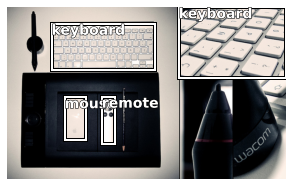

In [ ]:
im = PILImage.create(path/'train2017/000000260299.jpg')
bb = TensorBBox(dfd['bbs']['train2017/000000260299.jpg'])
lbl_str = dfd['cls']['train2017/000000260299.jpg']

ibl = ImageBBoxLabel((im,bb,lbl_str))
print(ibl)
ibl.show()

In [ ]:
ibl

im: PILImage mode=RGB size=640x395
bb: TensorBBox([[131.1700, 207.2900, 180.6200, 306.5900],
        [216.5600, 206.0800, 246.8600, 314.1300],
        [101.1900,  38.7800, 338.1900, 144.4100],
        [393.2200,   0.8900, 639.9900, 164.2100]])
lbl: ['mouse', 'remote', 'keyboard', 'keyboard']

Working on encodings; not necissary yet.

In [ ]:
cls = df['cls'].tolist()
cls_unpacked = ['background']
for i in cls: cls_unpacked = cls_unpacked + i
cls_unique = list(set(cls_unpacked))
test_eq(len(cls_unique), 81)

cls2int = {cls:i for i,cls in enumerate(cls_unique)}
lbl = L(lbl_str).map(lambda x:cls2enc[x]);lbl

(#4) [23,3,36,36]

## Bbox Transforms & DataLoader

`src` → `ds_raw` → `ds` → `dl`

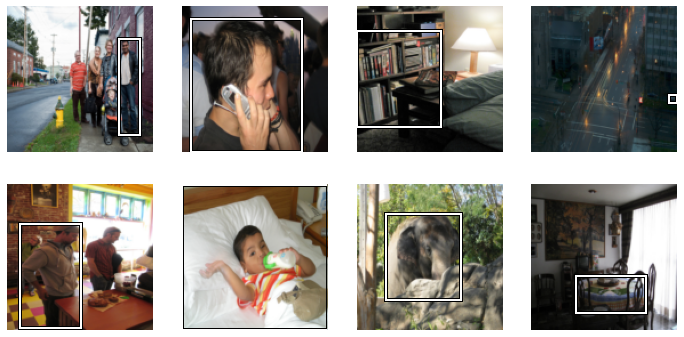

In [ ]:
# imbbs
fns = df['img'].tolist()
def fn2img(f): return PILImage.create(path/f)
ims = list(map(fn2img, fns))
def fn2bb(f): return TensorBBox.create(dfd['lrg_bb'][f])
bbs = list(map(fn2bb, fns))
imbbs = list(zip(ims,bbs))

# squish
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb*tensor(s/w, s/h, s/w, s/h)
squish = L(map(squish_imbb, imbbs))

# ds
fn2sq = {f[0]:(f[1][0],f[1][1]) for f in zip(fns,squish)}
def squished_im(f): return fn2sq[f][0]
def squished_bb(f): return fn2sq[f][1]
is_val = L(df['is_val'].tolist())
splits = L(~is_val, is_val)
ds = Datasets(fns,
              [squished_im,
               squished_bb],
              splits=splits, n_inp=1)

# dl
dl = TfmdDL(ds, bs=8
            ,after_item=[PointScaler(), ToTensor()]
            ,after_batch=[IntToFloatTensor()])

dl.show_batch()

In [ ]:
def fn2path(f): return path/f
paths = list(map(fn2path, fns))

bbdb = DataBlock(
    blocks=(ImageBlock, BBoxBlock),
    get_items=paths,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

NameError: name 'get_ctr' is not defined

In [ ]:
dls = DataLoaders(dl)

In [ ]:
b = dls.one_batch()

In [ ]:
xb,yb = dls.one_batch()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
xb.shape,yb.shape

SyntaxError: can't assign to function call (<ipython-input-30-2a548940053a>, line 1)

## WIP

### Attempting to find a better way to do the above...

I shouldn't be creating a single dataloader, I should be making a dataloaderS. I have enough now to significantly clean this stuff up and just make a DataBlock, though, so I'll try that.

In [ ]:
squish

(#611) [(PILImage mode=RGB size=128x128, TensorBBox([[ 97.3700,  28.4751, 116.1420, 113.0416]])),(PILImage mode=RGB size=128x128, TensorBBox([[  7.2220,  10.5013, 105.1220, 128.0000]])),(PILImage mode=RGB size=128x128, TensorBBox([[  0.0000,  21.5040,  74.0693, 105.2160]])),(PILImage mode=RGB size=128x128, TensorBBox([[120.7100,  77.3679, 127.8940,  84.2547]])),(PILImage mode=RGB size=128x128, TensorBBox([[ 10.7627,  34.7380,  64.1920, 125.8380]])),(PILImage mode=RGB size=128x128, TensorBBox([[  0.,   0., 128., 128.]])),(PILImage mode=RGB size=128x128, TensorBBox([[ 25.0240,  25.3120,  91.6860, 101.5360]])),(PILImage mode=RGB size=128x128, TensorBBox([[ 38.6500,  79.7920, 100.2380, 113.0400]])),(PILImage mode=RGB size=128x128, TensorBBox([[ 21.4480,  16.8839, 108.6440, 106.0506]])),(PILImage mode=RGB size=128x128, TensorBBox([[  9.4920,   1.7253, 110.2380, 113.9067]]))...]

In [ ]:
squim,squbb = [f[0] for f in squish], [f[1] for f in squish]

In [ ]:
L(squbb)

(#611) [TensorBBox([[ 97.3700,  28.4751, 116.1420, 113.0416]]),TensorBBox([[  7.2220,  10.5013, 105.1220, 128.0000]]),TensorBBox([[  0.0000,  21.5040,  74.0693, 105.2160]]),TensorBBox([[120.7100,  77.3679, 127.8940,  84.2547]]),TensorBBox([[ 10.7627,  34.7380,  64.1920, 125.8380]]),TensorBBox([[  0.,   0., 128., 128.]]),TensorBBox([[ 25.0240,  25.3120,  91.6860, 101.5360]]),TensorBBox([[ 38.6500,  79.7920, 100.2380, 113.0400]]),TensorBBox([[ 21.4480,  16.8839, 108.6440, 106.0506]]),TensorBBox([[  9.4920,   1.7253, 110.2380, 113.9067]])...]

In [ ]:
[tensor(0)]*3

[tensor(0), tensor(0), tensor(0)]

In [ ]:
def fn2path(f): return path/f
paths = list(map(fn2path, fns))

dfx = pd.DataFrame(
    {'fn':squim,
     'bb':squbb,
#      'cls':df['lrg_cls'].tolist(),
     'cls':['0']*len(squim),
     'is_valid':is_val
    })

In [ ]:
db = DataBlock(blocks=(ImageBlock, BBoxBlock, MultiCategoryBlock),
               get_x=ColReader(0),
               get_y=[ColReader(1), ColReader(2)],
               splitter=ColSplitter(),
               item_tfms=[PointScaler(), ToTensor()],
               batch_tfms=[IntToFloatTensor()],
               n_inp=1
              )

ds = db.datasets(dfx)
ds[0]

TypeError: invalid keyword arguments: bs

In [ ]:
dls = db.dataloaders(dfx, bs=8)

In [ ]:
db.summary(dfx)

Setting-up type transforms pipelines
0    PILImage mode=RGB size=128x128   
1    PILImage mode=RGB size=128x128   
2    PILImage mode=RGB size=128x128   
3    PILImage mode=RGB size=128x128   
4    PILImage mode=RGB size=128x128   
..                              ...   
606  PILImage mode=RGB size=128x128   
607  PILImage mode=RGB size=128x128   
608  PILImage mode=RGB size=128x128   
609  PILImage mode=RGB size=128x128   
610  PILImage mode=RGB size=128x128   

                                                                           bb  \
0    [[tensor(97.3700), tensor(28.4751), tensor(116.1420), tensor(113.0416)]]   
1         [[tensor(7.2220), tensor(10.5013), tensor(105.1220), tensor(128.)]]   
2          [[tensor(0.), tensor(21.5040), tensor(74.0693), tensor(105.2160)]]   
3    [[tensor(120.7100), tensor(77.3679), tensor(127.8940), tensor(84.2547)]]   
4     [[tensor(10.7627), tensor(34.7380), tensor(64.1920), tensor(125.8380)]]   
..                                             

In [ ]:
dls.one_batch()

(TensorImage([[[[0.0157, 0.0157, 0.0235,  ..., 0.0863, 0.0824, 0.0706],
           [0.0196, 0.0314, 0.0235,  ..., 0.1843, 0.2353, 0.2431],
           [0.0392, 0.0549, 0.0314,  ..., 0.3176, 0.4157, 0.4745],
           ...,
           [0.0824, 0.0824, 0.0824,  ..., 0.4863, 0.4431, 0.4157],
           [0.0745, 0.0784, 0.0824,  ..., 0.4314, 0.3961, 0.3529],
           [0.0627, 0.0667, 0.0706,  ..., 0.3725, 0.3098, 0.2627]],
 
          [[0.0275, 0.0353, 0.0431,  ..., 0.0353, 0.0588, 0.0863],
           [0.0510, 0.0549, 0.0431,  ..., 0.0667, 0.1529, 0.2824],
           [0.0706, 0.0824, 0.0510,  ..., 0.1098, 0.3020, 0.5176],
           ...,
           [0.0902, 0.0902, 0.0902,  ..., 0.4980, 0.4667, 0.4392],
           [0.0824, 0.0863, 0.0902,  ..., 0.4431, 0.4118, 0.3725],
           [0.0706, 0.0745, 0.0784,  ..., 0.3843, 0.3216, 0.2863]],
 
          [[0.0078, 0.0118, 0.0118,  ..., 0.0392, 0.0588, 0.0941],
           [0.0118, 0.0118, 0.0118,  ..., 0.0745, 0.1608, 0.2941],
           [0.0157,

In [ ]:
def show_imbb(imbb): imbb_ctx = imbb[0].show(); imbb[1].show(ctx=imbb_ctx)

### CropBBox Transform – make this work later

Goal is to get this working:

In [ ]:
# aug_trans = [Zoom(), CropBBox(), CropCoords(), Flip(), Brightness(), Contrast()]

In [ ]:
def minmax(x): return max(min(1.,x),-1.)

class CropCoords(Transform):
    def encodes(self, bb:TensorBBox): return bb.apply_(minmax)

In [ ]:
b[1]

TensorBBox([[[-1.0000, -0.7546,  1.0000,  0.9719]],

        [[-1.0000,  0.2382,  1.0000,  1.0000]],

        [[-0.1874,  0.1174,  0.5831,  0.9210]],

        [[-0.6852, -0.7483,  0.3283,  0.6719]],

        [[ 0.0216, -0.7167,  0.7075,  0.5761]],

        [[-0.3007, -0.9045,  0.2702,  0.8156]],

        [[-0.5606, -0.7550,  1.0000,  1.0000]],

        [[-0.9940, -0.2000,  0.6057,  0.9730]]])

In [ ]:
fnames[0]

'train2017/000000580829.jpg'

In [ ]:
fn2sq = {f[0]:(f[1][0],f[1][1]) for f in zip(fnames,squish)}
fn2sq[fnames[0]]

(PILImage mode=RGB size=128x128,
 TensorBBox([[22.7547, 74.1140, 36.3227, 82.5720]]))

In [ ]:
ds = Datasets(fnames,
              [squished_im,squished_bb],
              splits=splits,
              n_inp=1)

ds[0]

(PILImage mode=RGB size=128x128,
 TensorBBox([[22.7547, 74.1140, 36.3227, 82.5720]]))

In [ ]:
# ds_squished
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb*tensor(s/w, s/h, s/w, s/h)

ds_sq = L(map(squish_imbb, ds_src))
ds_sq[0]

NameError: name 'ds_src' is not defined

In [ ]:
f = CropCoords()
c = f(b)
c[1][0:3]

tensor([[[-1.0000, -0.7546,  1.0000,  0.9719]],

        [[-1.0000,  0.2382,  1.0000,  1.0000]],

        [[-0.1874,  0.1174,  0.5831,  0.9210]]])

In [ ]:
b[0][0]

tensor([[[0.5843, 0.5922, 0.5765,  ..., 0.2510, 0.2471, 0.1608],
         [0.5137, 0.5765, 0.5882,  ..., 0.3608, 0.3490, 0.2510],
         [0.5647, 0.5373, 0.5961,  ..., 0.3569, 0.3569, 0.3255],
         ...,
         [0.7569, 0.7725, 0.7647,  ..., 0.6588, 0.6275, 0.6392],
         [0.7529, 0.7569, 0.7490,  ..., 0.6039, 0.6000, 0.6000],
         [0.7569, 0.7490, 0.7294,  ..., 0.6000, 0.6431, 0.6353]],

        [[0.4824, 0.4784, 0.4784,  ..., 0.3216, 0.3176, 0.2510],
         [0.4314, 0.4784, 0.4941,  ..., 0.3882, 0.3765, 0.2941],
         [0.4902, 0.4745, 0.5176,  ..., 0.4000, 0.3804, 0.3373],
         ...,
         [0.7765, 0.7843, 0.7804,  ..., 0.6549, 0.6235, 0.6353],
         [0.7725, 0.7686, 0.7686,  ..., 0.5961, 0.6000, 0.6039],
         [0.7765, 0.7686, 0.7490,  ..., 0.6157, 0.6549, 0.6549]],

        [[0.2941, 0.2863, 0.2941,  ..., 0.1882, 0.1843, 0.1686],
         [0.2510, 0.2941, 0.2980,  ..., 0.2431, 0.2588, 0.2078],
         [0.3176, 0.3059, 0.3451,  ..., 0.2706, 0.2824, 0.

In [ ]:
# ds
is_val = L(df['is_val'].tolist())
splits = L(~is_val, is_val)

ds = Datasets(items=ds_sqsh, splits=splits,n_inp=1)
ds[0]

((PILImage mode=RGB size=128x128,
  TensorBBox([[22.7547, 74.1140, 36.3227, 82.5720]])),)

(#122) [((PILImage mode=RGB size=128x128, TensorBBox([[ 44.6962,  19.5456, 114.7195, 105.5411]])),),((PILImage mode=RGB size=128x128, TensorBBox([[  0.0000,  17.9867, 128.0000, 125.7600]])),),((PILImage mode=RGB size=128x128, TensorBBox([[ 12.5040,  44.5847, 101.7580,  84.2796]])),),((PILImage mode=RGB size=128x128, TensorBBox([[  0.3640,  27.9823,  54.0580, 128.0000]])),),((PILImage mode=RGB size=128x128, TensorBBox([[ 25.3212,  63.8840, 100.4305, 113.7100]])),),((PILImage mode=RGB size=128x128, TensorBBox([[  0.0000,  53.0944, 128.0000, 126.5664]])),),((PILImage mode=RGB size=128x128, TensorBBox([[51.5520, 22.9960, 82.3307, 98.0760]])),),((PILImage mode=RGB size=128x128, TensorBBox([[ 34.1640,  74.3243,  60.8220, 104.9630]])),),((PILImage mode=RGB size=128x128, TensorBBox([[ 38.5652,   5.3187, 128.0000, 126.0047]])),),((PILImage mode=RGB size=128x128, TensorBBox([[54.4860, 66.4507, 70.7020, 97.8747]])),)...]

((PILImage mode=RGB size=128x128, TensorBBox([[ 44.6962,  19.5456, 114.7195

In [ ]:
# dl
dl = TfmdDL(ds, bs=8,
            after_item=[PointScaler(), ToTensor()]
            ,after_batch=[IntToFloatTensor(), Flip(), Brightness(), Contrast()])
b = dl.one_batch()

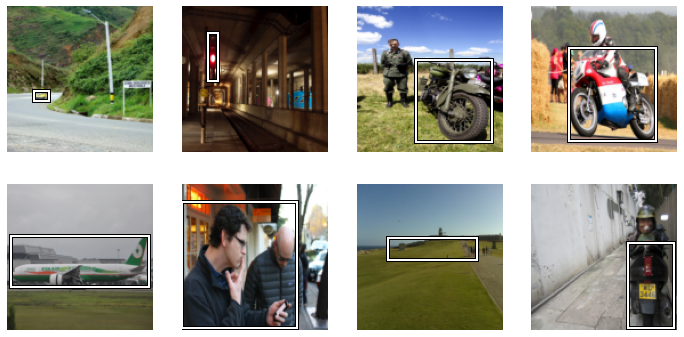

### Examples

#### COCO

Taken from the bottom of this page: https://docs.fast.ai/vision.augment#All-together

In [ ]:
fn2sq = {f[0]:(f[1][0],f[1][1]) for f in zip(fnames,squish)}

(#10) [(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48

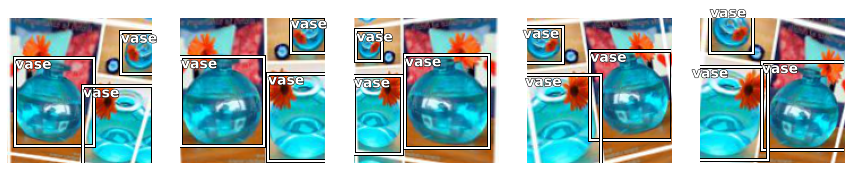

In [ ]:
coco = untar_data(URLs.COCO_TINY)                     # grabbed data
images, lbl_bbox = get_annotations(coco/'train.json') # unpack annotations
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx] # return (path, [bboxs, lbls])

def _coco_bb(x):  return TensorBBox.create(bbox[0])   # return bboxes::T(L(L(floats)) for each img
def _coco_lbl(x): return bbox[1]                      # return labels::L(strs) for each img

coco_dsrc = Datasets([coco_fn]*10,       # src::list
                     [PILImage.create,   # [img, bbs, labels]
                      [_coco_bb],
                      [_coco_lbl, MultiCategorize(add_na=True)]],
                     n_inp=1)

coco_tdl = TfmdDL(coco_dsrc, bs=8,
                  after_item=[BBoxLabeler(), PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

print(coco_dsrc)
coco_tdl.show_batch(nrows=1,ncols=5)

#### COCO w/o labels

(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]))


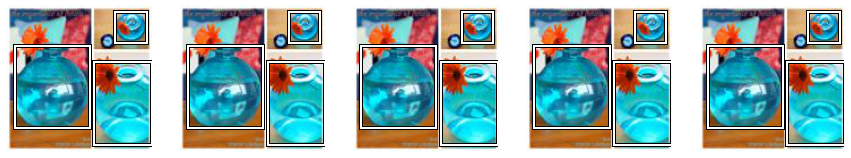

In [ ]:
def coco_bb(x):  return TensorBBox.create(bbox[0])
coco_src = [coco_fn]*10

coco_ds = Datasets(coco_src,
                   [PILImage.create, coco_bb], # transform coco_src into tuple of len 2
                   n_inp=1)

coco_tdl = TfmdDL(coco_dsrc, bs=8,
                  after_item=[PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

print(coco_ds[0])
coco_tdl.show_batch(nrows=1,ncols=5)

In [ ]:
fn2sq['train2017/000000580829.jpg']

(PILImage mode=RGB size=128x128,
 TensorBBox([[22.7547, 74.1140, 36.3227, 82.5720]]))

#### COCO with DataBlocks API

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [ ]:
PILImage.create(coco_source/'train'/images[2]).size

(128, 128)

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

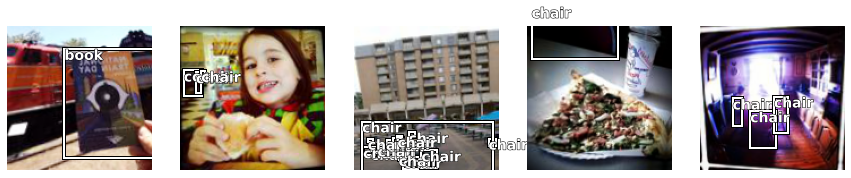

In [ ]:
dls = coco.dataloaders(coco_source)
dls.show_batch(nrows=1,ncols=5)

In [ ]:
xim,ybb,ylbl = dls.one_batch(); xim[0]

tensor([[[0.7411, 0.7777, 0.5257,  ..., 0.6685, 0.4317, 0.2346],
         [0.7390, 0.7730, 0.5252,  ..., 0.7171, 0.5196, 0.3076],
         [0.7332, 0.7672, 0.5235,  ..., 0.7460, 0.5305, 0.2662],
         ...,
         [0.7830, 0.7835, 0.7600,  ..., 0.6108, 0.5955, 0.5805],
         [0.7683, 0.7709, 0.7840,  ..., 0.7175, 0.7025, 0.6807],
         [0.7836, 0.7828, 0.8025,  ..., 0.8698, 0.8419, 0.7996]],

        [[0.7022, 0.7289, 0.4634,  ..., 0.6538, 0.4226, 0.2369],
         [0.7048, 0.7325, 0.4744,  ..., 0.6876, 0.4982, 0.2998],
         [0.7010, 0.7319, 0.4828,  ..., 0.7129, 0.5061, 0.2580],
         ...,
         [0.7334, 0.7344, 0.7126,  ..., 0.3529, 0.3552, 0.3694],
         [0.7062, 0.7091, 0.7142,  ..., 0.5221, 0.5136, 0.5071],
         [0.7077, 0.7074, 0.7058,  ..., 0.7390, 0.7108, 0.6788]],

        [[0.6975, 0.7306, 0.4754,  ..., 0.7267, 0.5439, 0.3953],
         [0.6977, 0.7345, 0.4831,  ..., 0.7643, 0.6192, 0.4564],
         [0.6929, 0.7324, 0.4869,  ..., 0.7843, 0.6164, 0.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))

In [ ]:
activs = learn.model(xim.cpu())

In [ ]:
activs.shape

torch.Size([64, 4])

In [ ]:
activs[0:3]

tensor([[-0.2573,  0.6406, -0.4675, -1.3349],
        [ 0.6922,  0.5272, -1.2859,  0.5505],
        [-1.8915, -1.9482, -0.2614,  2.3723]], grad_fn=<SliceBackward>)

In [ ]:
dls.vocab

(#7) ['#na#','book','chair','couch','remote','tv','vase']

In [ ]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

TypeError: __call__() takes 3 positional arguments but 4 were given

In [ ]:
x,y1,y2 = dls.train.one_batch(); y2

TensorMultiCategory([[2, 2, 2,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [6, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [4, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [ ]:
activs = learn.model(x)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
learn.fine_tune(1)

> /home/rory/repos/fastai/fastai2/learner.py(166)_do_one_batch()
    164         self.pred = self.model(*self.xb);                self('after_pred')
    165         if len(self.yb) == 0: return
--> 166         self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
    167         if not self.training: return
    168         self('before_backward')

ipdb> self.loss
ipdb> print(self.loss)
None
ipdb> p self.pred
None
ipdb> p *self.yb
*** SyntaxError: invalid syntax
ipdb> print(self.yb)
(None,)
ipdb> e
*** NameError: name 'e' is not defined
ipdb> x
*** NameError: name 'x' is not defined
ipdb> exit


TypeError: __call__() takes 3 positional arguments but 4 were given

None


#### MNIST

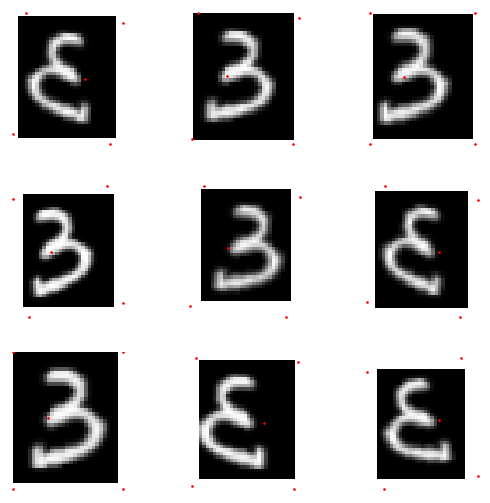

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
mnist_fn = 'train/3/7590.png'
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
def get_mnist_path(fn): return mnist/fn
def _pnt_lbl(fn)->None: return TensorPoint.create(pnts)

pnt_dsrc = Datasets([mnist_fn]*10,
                    [[get_mnist_path, PILImage.create, Resize((35,28))],
                     _pnt_lbl])

pnt_tdl = TfmdDL(pnt_dsrc.train, bs=9,
                 after_item=[PointScaler(), ToTensor()],
                 after_batch=[IntToFloatTensor(), *aug_transforms(max_warp=0)])

pnt_tdl.show_batch(max_n=9)

## BBox Learner

In [ ]:
doc(cnn_learner)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2), n_out=5, y_range=(-1,1))

In [ ]:
x,y,z = dls.train.one_batch()
x.shape,y.shape,z.shape

(torch.Size([8, 3, 128, 128]), torch.Size([8, 1, 4]), torch.Size([8, 1]))

In [ ]:
activs = learn.model(x.cpu())
activs.shape

torch.Size([8, 5])

In [ ]:
activs[0]

tensor([-0.7292,  0.3889,  0.3064,  0.0096, -0.4904], grad_fn=<SelectBackward>)

In [ ]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
x

TensorImage([[[[-1.2959, -1.4500, -1.5870,  ..., -1.7240, -1.6384, -1.5528],
          [-1.8268, -1.7412, -1.7240,  ..., -1.6555, -1.6898, -1.7069],
          [-1.7240, -1.7925, -1.7412,  ..., -1.7069, -1.7240, -1.6384],
          ...,
          [-1.3130, -1.1247, -1.1247,  ..., -0.9877, -0.7308, -0.6794],
          [-1.2445, -1.0904, -1.0904,  ..., -0.9705, -0.7650, -0.5767],
          [-1.2274, -1.1760, -1.1932,  ..., -0.9363, -0.9363, -0.6965]],

         [[-0.5651, -0.6527, -1.0553,  ..., -1.2479, -1.0378, -0.9853],
          [-1.2129, -1.0203, -1.0728,  ..., -1.1779, -1.2304, -1.3179],
          [-1.1954, -1.2129, -1.1954,  ..., -1.3880, -1.2829, -1.2129],
          ...,
          [-1.1779, -1.0203, -1.0028,  ..., -1.1429, -0.9328, -0.9153],
          [-1.1604, -0.9853, -0.9678,  ..., -1.1604, -1.0028, -0.9153],
          [-1.1604, -1.0553, -1.0728,  ..., -1.1429, -1.1429, -1.0378]],

         [[-1.1421, -1.4559, -1.5256,  ..., -1.4559, -1.3513, -1.1596],
          [-1.5953, -1.59

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)

ValueError: Target size (torch.Size([8, 1, 4])) must be the same as input size (torch.Size([8, 5]))

In [ ]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

TypeError: __call__() takes 3 positional arguments but 4 were given

# Chalk board

In [ ]:
cnn_learner?

## Creating my own Transform (https://docs.fast.ai/tutorial.pets)

##### Dogs

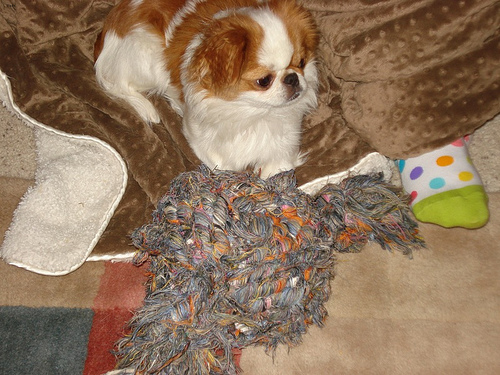

In [ ]:
source = untar_data(URLs.PETS)
items = get_image_files(source/"images")
img = PILImage.create(items[0])
img

In [ ]:
from albumentations import ShiftScaleRotate

In [ ]:
aug = ShiftScaleRotate(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

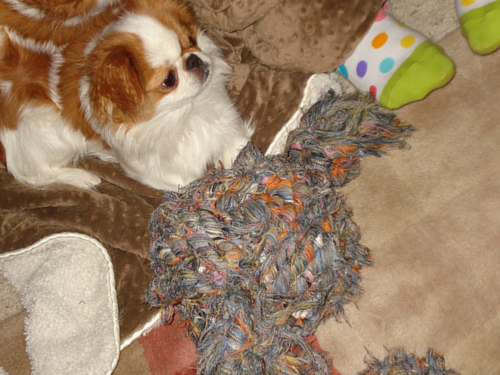

In [ ]:
aug_tfm(img)

In [ ]:
type(aug_tfm)

function

In [ ]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

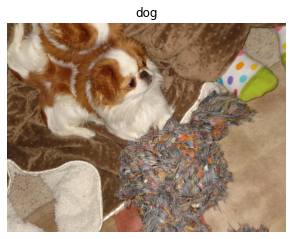

In [ ]:
tfm = AlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, 'dog'))
show_image(a, title=b);

##### Masks

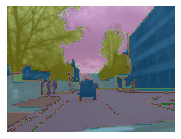

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
img = PILImage.create(cv_items[0])
mask = PILMask.create(cv_source/'labels'/f'{cv_items[0].stem}_P{cv_items[0].suffix}')
ax = img.show()
ax = mask.show(ctx=ax)

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

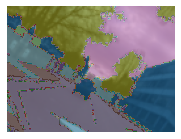

In [ ]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, mask))
ax = a.show()
ax = b.show(ctx=ax)

## Steps taken to discover squish_imbb

What I'm working with:

(PILImage mode=RGB size=500x335, TensorBBox([[ 10.5200,  24.4900, 387.5800, 168.7000]]))


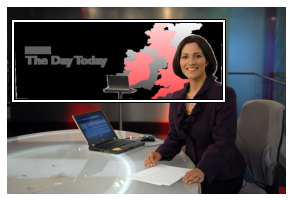

In [ ]:
imbb = ds.train[0]
print(imbb)
type(imbb)

def show_imbb(imbb): imbb_ctx = imbb[0].show(); imbb[1].show(ctx=imbb_ctx)
show_imbb(imbb)

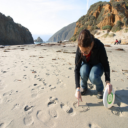

In [ ]:
scale_im = Resize(128, ResizeMethod.Squish)
imr = scale_im(im)
imr

In [ ]:
bb

TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]])

In [ ]:
bb[0]

tensor([364.7700,  95.6900, 558.1600, 361.8500])

In [ ]:
bb[0][0]

tensor(364.7700)

In [ ]:
bb[0][0],bb[0][1],bb[0][2],bb[0][3]

(tensor(364.7700), tensor(95.6900), tensor(558.1600), tensor(361.8500))

In [ ]:
bbx = TensorBBox([bb[0][0],bb[0][1],bb[0][2],bb[0][3]]); bbx

TensorBBox([364.7700,  95.6900, 558.1600, 361.8500])

TensorBBox([ 72.9540,  28.6846, 111.6320, 108.4703])


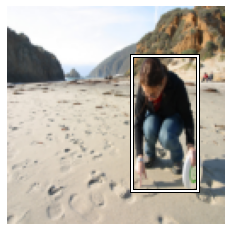

In [ ]:
s = 128
w,h = im.size
sw,sh = s/w, s/h
bbr = TensorBBox([sw*bb[0][0],
                  sh*bb[0][1],
                  sw*bb[0][2],
                  sh*bb[0][3]])
print(bbr)
ctx = imr.show(); bbr.show(ctx=ctx)

In [ ]:
squish_im = Resize(128, ResizeMethod.Squish)

In [ ]:
l = tensor(1,2,3)
m = tensor([2],[2],[2])
n = tensor(2,2,2)
nn = tensor(1,2,3)
l*m
l*nn

bbx = TensorBBox([[1,2,3,4]])
bbx * tensor(1,2,1,2)

TensorBBox([[1, 4, 3, 8]])

In [ ]:
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb * tensor(s/w,s/h,s/w,s/h)

(PILImage mode=RGB size=640x427, TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]]))
(PILImage mode=RGB size=128x128, TensorBBox([[ 72.9540,  28.6846, 111.6320, 108.4703]]))


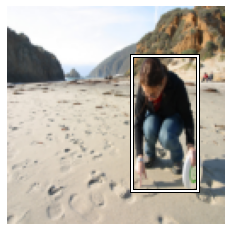

In [ ]:
imbbr = squish_imbb(imbb)
print(imbb)
print(imbbr)
ctx = imbbr[0].show(); imbbr[1].show(ctx=ctx)

In [ ]:
ds[1]

(PILImage mode=RGB size=640x360,
 TensorBBox([[129.2100,  76.5900, 236.4800, 342.3300]]))

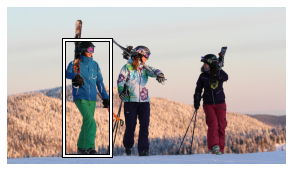

In [ ]:

show_imbb(ds[1])

# Abandoned Scratch

In [ ]:
###
###
### Other

In [ ]:
class ResizeBBox(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, bb: PILImage):
        aug_img = self.aug(image=np.array(b))['image']
        return PILImage.create(aug_img)

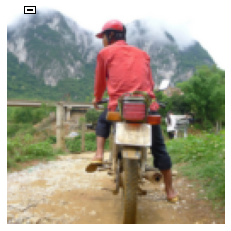

In [ ]:
ctx = imr.show()
bboxrr.show(ctx=ctx)

In [ ]:
r=Resize(128)
r

Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection'}:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(Image,object) -> encodes
decodes: 

Pipeline: (Image, Bbox, Label)
1. Bbox to Point
2. PointScaler
3. Resize Img
4. Resize Point
5. Point to BBox

In [ ]:
def bbox2pt(ibl):
    i,b,l = ibl
    return i, TensorPoint.create(b), l

def pt2bbox(ibl):
    i,b,l = ibl
    return i, TensorBBox([[*b[0],*b[1]]]), l

def resize_bbox(ibl):
    i,b,l = ibl
    return i, aug(b,im.size), l

ibl = im,bbox,'foo'
ipl = bbox2pt(ibl)
iblr = pt2bbox(ipl)
test_eq(ibl, iblr)

In [ ]:
Bbox2pt = Transform(bbox2pt)
Pt2bbox = Transform(pt2bbox)
Resize_bbox = Transform(resize_bbox)

In [ ]:
trans = Pipeline([Bbox2pt, PointScaler(), Resize(128), Pt2bbox, Resize_bbox])